In [63]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
#from  tueplots import bundles


# Plug any of those into either the rcParams or into an rc_context:

#plt.rcParams.update(bundles.probnum2025())




onwards_2016 = False
add_to_fig = "from_2016_onwards" if onwards_2016 else ""

First, we load the data and exclude Australia ( to far away), Marocco (only participated once) 
and Yugslawia and Serbia-Montenegro ( both historic states)

We check that all our data have values on the most simple points

In [64]:
# Load the data
votes = pd.read_csv("../data/fulldata.csv")

votes["round"] = votes["round"].astype("category")

votes = votes[votes["distance"] > 0]
votes = votes[votes["round"] == "final"]


votes = votes[votes["from_country"] != votes["to_country"]] #exclude self-votes
votes = votes[~votes["to_country"].isin(["au", "yu", "cs", "ma"])] # exclude Australia, Yugoslavia, Serbia and Montenegro, Morocco
votes = votes[~votes["from_country"].isin(["au", "yu", "cs", "ma"])] # exclude Australia, Yugoslavia, Serbia and Montenegro, Morocco
if onwards_2016:
    votes = votes[votes["year"] >= 2016] #exclude years before 2016

length_before = len(votes)
print("Rows before dropping NA Collums:", length_before)
votes.columns
votes = votes.dropna(subset=["from_country", "to_country", "distance", "total_points"])
length_after = len(votes)

print("Dropped", length_before - length_after, "rows due to missing values")

print("Rows before dropping NA after forcing numeric:", length_before)
length_before = length_after
print(votes.columns)

Rows before dropping NA Collums: 34061
Dropped 0 rows due to missing values
Rows before dropping NA after forcing numeric: 34061
Index(['Unnamed: 0', 'year', 'round', 'from_country', 'to_country',
       'total_points', 'tele_points', 'jury_points', 'Year_from',
       'iso-alpha-3_from', 'chrstprotpct_from', 'chrstcatpct_from',
       'chrstorthpct_from', 'judgenpct_from', 'islmgenpct_from',
       'nonreligpct_from', 'StateAbb_from', 'city_from', 'lat_from',
       'lon_from', 'GDP per capita (current US$)_from',
       'Population, total_from', 'Year_to', 'iso-alpha-3_to',
       'chrstprotpct_to', 'chrstcatpct_to', 'chrstorthpct_to', 'judgenpct_to',
       'islmgenpct_to', 'nonreligpct_to', 'StateAbb_to', 'city_to', 'lat_to',
       'lon_to', 'GDP per capita (current US$)_to', 'Population, total_to',
       'distance', 'jaccard_artists', 'jaccard_genre', 'dice_genre',
       'dice_artists'],
      dtype='object')


/tmp/ipykernel_1738/840765235.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("../data/fulldata.csv")


Now we check if all the GDP data is actually numeric and drop rows that are not. We can track, how many  values are now missing. 
San Mario is missing GDP  values for 2023

In [65]:
votes
subset=["GDP per capita (current US$)_from", "GDP per capita (current US$)_to"]

length_before = len(votes)
votes.replace("..",float("nan"),inplace=True)

#print(votes['GDP per capita (current US$)_to'])
votes["GDP per capita (current US$)_from"] = pd.to_numeric(votes["GDP per capita (current US$)_from"], errors='coerce')
votes["GDP per capita (current US$)_to"] = pd.to_numeric(votes["GDP per capita (current US$)_to"], errors='coerce')
rows_with_na = votes[votes[subset].isna().any(axis=1)]

print("Rows with missing values:")
print(rows_with_na)
votes = votes.dropna(subset=subset)
length_after = len(votes)
print("Dropped", length_before - length_after, "rows due to missing values in GDP per capita")
print("Rows after dropping NA:", length_after)




Rows with missing values:
       Unnamed: 0  year  round from_country to_country  total_points  \
2               2  1960  final           at         mc             0   
14             14  1960  final           be         mc             0   
26             26  1960  final           dk         mc             2   
37             37  1960  final           fr         mc             3   
50             50  1960  final           de         mc             7   
...           ...   ...    ...          ...        ...           ...   
47241       47241  2023  final           sm         al             0   
47242       47242  2023  final           sm         pt             0   
47243       47243  2023  final           sm         rs             0   
47244       47244  2023  final           sm         gb             0   
47245       47245  2023  final           sm         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...   city_to  \
2              NaN          NaN

The religios data does not include Serbia, so we can right  anywway.
As you can see for 2016>= the relgion data is complete otherwise

In [66]:
#Compute difference so that we can use that as varible in the regression

votes["GDP_Difference"] = votes["GDP per capita (current US$)_from"] - votes["GDP per capita (current US$)_to"]

if onwards_2016:
    # we know that this data is incomplete , so we will only look at newer data, where we have more complete data
    religious_differences = ["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference", "Orthodox_Difference"]
    votes = votes[~votes["from_country"].isin(["rs"])] #exclude Serbia
    votes = votes[~votes["to_country"].isin(["rs"])] #exclude Serbia

    
    votes["Catholism_Difference"] = votes["chrstcatpct_from"] - votes["chrstcatpct_to"]

    votes["Protestant_Difference"] = votes["chrstprotpct_from"] - votes["chrstprotpct_to"]

    votes["Islam_Difference"] = votes["islmgenpct_from"] - votes["islmgenpct_to"]

    votes["Judaism_Difference"] = votes["judgenpct_from"] - votes["judgenpct_to"]

    votes["Orthodox_Difference"] = votes["chrstorthpct_from"] - votes["chrstorthpct_to"]

    votes["Non_religious_Difference"] = votes["nonreligpct_from"] - votes["nonreligpct_to"]

    length_before = len(votes)
    print("Rows before dropping NA Collums:", length_before)

    rows_with_na = votes[votes[religious_differences].isna().any(axis=1)]

    print("Rows with missing values:")
    print(rows_with_na)
    votes = votes.dropna(subset=["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference"])
    length_after = len(votes)
    print("Dropped", length_before - length_after, "rows due to missing values in religion data")

In [67]:
votes.head

<bound method NDFrame.head of        Unnamed: 0  year  round from_country to_country  total_points  \
0               0  1960  final           at         fr             1   
1               1  1960  final           at         gb             3   
3               3  1960  final           at         no             1   
4               4  1960  final           at         de             2   
5               5  1960  final           at         be             1   
...           ...   ...    ...          ...        ...           ...   
47416       47416  2023  final           gb         si             1   
47417       47417  2023  final           gb         al             0   
47418       47418  2023  final           gb         pt             0   
47419       47419  2023  final           gb         rs             0   
47420       47420  2023  final           gb         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...  \
0              NaN          NaN      

We normalize the continous variable to better compare effect size

In [68]:
votes["distance"] = votes["distance"].astype("int")

#Normalize the data
distance_mean = votes["distance"].mean()
distance_std = votes["distance"].std()
votes["distance"] = (votes["distance"] - distance_mean) / distance_std
votes["GDP_Difference"] = (votes["GDP_Difference"] - votes["GDP_Difference"].mean()) / votes[
    "GDP_Difference"
].std()

if onwards_2016:
    votes["Catholism_Difference"] = (votes["Catholism_Difference"] - votes["Catholism_Difference"].mean()) / votes[
        "Catholism_Difference"
    ].std()
    votes["Protestant_Difference"] = (votes["Protestant_Difference"] - votes["Protestant_Difference"].mean()) / votes[
        "Protestant_Difference"
    ].std()

    votes["Orthodox_Difference"] = (votes["Orthodox_Difference"] - votes["Orthodox_Difference"].mean()) / votes["Orthodox_Difference"].std()
    votes["Islam_Difference"] = (votes["Islam_Difference"] - votes["Islam_Difference"].mean()) / votes[
        "Islam_Difference"
    ].std()
    votes["Judaism_Difference"] = (votes["Judaism_Difference"] - votes["Judaism_Difference"].mean()) / votes[
        "Judaism_Difference"
    ].std()

    votes["Non_religious_Difference"] = (votes["Non_religious_Difference"] - votes["Non_religious_Difference"].mean()) /  votes["Non_religious_Difference"].std()




In [69]:
re_formula = "~1"


if onwards_2016:
    print("Running model from 2016 onwards")
    """mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + Catholism_Difference + Protestant_Difference + Islam_Difference + Judaism_Difference +  Non_religious_Difference+ Orthodox_Difference+ dice_genre + dice_artists",
        data=votes,
        re_formula="1",
        groups=votes["from_country"],
    ).fit(reml=False)"""

    tele_model = smf.mixedlm("tele_points ~ distance + GDP_Difference +  dice_genre + dice_artists", re_formula=re_formula, data=votes, groups=votes["from_country"]).fit(reml=False)

    jury_model = smf.mixedlm("jury_points ~ distance + GDP_Difference + dice_genre + dice_artists",  re_formula=re_formula,data=votes, groups=votes["from_country"]).fit(reml=False)


    
else:
    
    print("Running model without religion data")
    mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + dice_genre + dice_artists",
        re_formula=re_formula, 
        data=votes,
        groups=votes["from_country"],
    ).fit(reml=False)


    
    
    votes["residuals"] = mixed_model.resid
    votes["fitted_values"] = mixed_model.fittedvalues
    print(mixed_model.summary())
    print("Quality of fit:",mixed_model.aic)
    print("p_values:", mixed_model.pvalues)

    

Running model without religion data


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_points
No. Observations: 33700   Method:             ML          
No. Groups:       47      Scale:              17.0057     
Min. group size:  170     Log-Likelihood:     -95605.6467 
Max. group size:  1243    Converged:          Yes         
Mean group size:  717.0                                   
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       2.590    0.075  34.363 0.000  2.442  2.738
distance       -0.504    0.027 -18.618 0.000 -0.557 -0.451
GDP_Difference  0.082    0.028   2.970 0.003  0.028  0.137
dice_genre     -0.122    0.193  -0.630 0.529 -0.500  0.257
dice_artists    1.152    0.184   6.256 0.000  0.791  1.513
Group Var       0.132    0.009                            

Quality of fit: 191225.29344059643
p_values: Intercept         8.8

We also create a model w/o the distance so we can compare the quality of the fit and have some estimation if we overfit

In [70]:
if  not onwards_2016:
    w_o_distance = smf.mixedlm("total_points ~ GDP_Difference + dice_genre + dice_artists", data=votes,  re_formula=re_formula,groups=votes["from_country"]).fit(reml=False)
    print(w_o_distance.summary())
    print("Quality of fit:",w_o_distance.aic)
    print("p_values:", w_o_distance.pvalues)

    difference_as_prob = np.exp((mixed_model.aic - w_o_distance.aic)/2)
    print("Difference as probability" , difference_as_prob)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_points
No. Observations: 33700   Method:             ML          
No. Groups:       47      Scale:              17.2154     
Min. group size:  170     Log-Likelihood:     -95780.1620 
Max. group size:  1243    Converged:          Yes         
Mean group size:  717.0                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        2.370    0.052 45.243 0.000  2.268  2.473
GDP_Difference   0.013    0.028  0.471 0.637 -0.041  0.067
dice_genre      -0.206    0.181 -1.142 0.254 -0.561  0.148
dice_artists     1.758    0.176  9.993 0.000  1.413  2.103
Group Var        0.014    0.003                           

Quality of fit: 191572.32409021835
p_values: Intercept         0.000000e+00
GDP_Difference    6.373269e-01
dice_genre        

In [71]:
if  not onwards_2016:
    just_distance = smf.mixedlm("total_points ~distance", data=votes,  re_formula=re_formula,groups=votes["from_country"]).fit(reml=False)
    print(just_distance.summary())
    print("Quality of fit:",just_distance.aic)
    print("p_values:", just_distance.pvalues)

    difference_as_prob_just_distance = np.exp((mixed_model.aic - just_distance.aic)/2)
    print("Difference as probability for just distance" , difference_as_prob_just_distance)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_points
No. Observations: 33700   Method:             ML          
No. Groups:       47      Scale:              17.0428     
Min. group size:  170     Log-Likelihood:     -95641.2244 
Max. group size:  1243    Converged:          Yes         
Mean group size:  717.0                                   
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   2.941     0.057   51.366  0.000   2.829   3.054
distance   -0.547     0.026  -20.792  0.000  -0.598  -0.495
Group Var   0.125     0.008                                

Quality of fit: 191290.4488915904
p_values: Intercept    0.000000e+00
distance     5.139643e-96
Group Var    2.449246e-04
dtype: float64
Difference as probability for just distance 7.106791654802058e-15


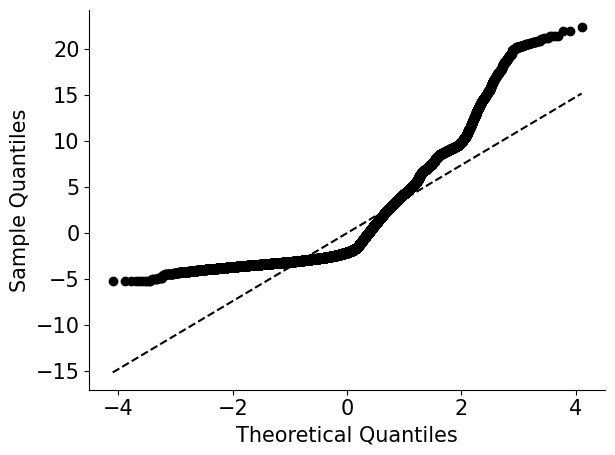

In [72]:
def display_q_q_plot(residual_name):
    import scipy.stats as stats
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots()
    stats.probplot(votes[residual_name], dist="norm", plot=plt)
    plt.title("")
    plt.grid(False)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_lines()[0].set_color('black')  # Data points (scatter)
    ax.get_lines()[1].set_color('black')  # Regression line
    ax.get_lines()[1].set_linestyle('--')
    plt.tight_layout()
    #plt.xlabel("Theoretical quantiles", fontsize=15)
    plt.savefig("../plots/linear_effects/q_q_plot_" + residual_name + add_to_fig + ".png", bbox_inches='tight')
    plt.rcParams.update({'font.size': 10})

    return  plt.show()

if not onwards_2016:
    display_q_q_plot("residuals")

In [73]:
if onwards_2016:
    print("tele model:")
    print(tele_model.summary())
    

    votes["tele_predicted"] = tele_model.fittedvalues
    #votes["jury_predicted"] = jury_model.fittedvalues
    votes["tele_residuals"] = tele_model.resid
    #votes["jury_residuals"] = jury_model.resid

In [74]:
if onwards_2016:
    display_q_q_plot("tele_residuals")
    print("GOodness of fit:")
    print(tele_model.llf)

In [75]:
if onwards_2016:
    
    print("jury model:")
    print(jury_model.summary())


    #adding residuals to the data
    

In [76]:
#display_q_q_plot("jury_residuals")

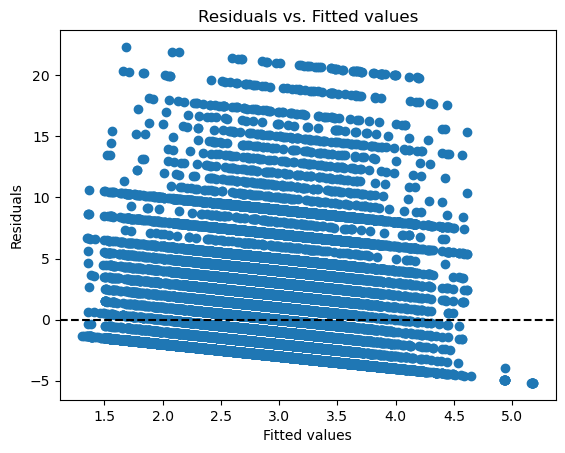

In [77]:

if not onwards_2016:

    # Plot the residuals
    plt.scatter(votes["fitted_values"], votes["residuals"])
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Fitted values")
    plt.axhline(y=0, color="black", linestyle="--")
    plt.savefig("../plots/linear_effects/residuals_vs_fitted_values" + add_to_fig + ".png")
    plt.show()

/tmp/ipykernel_1738/820370157.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')


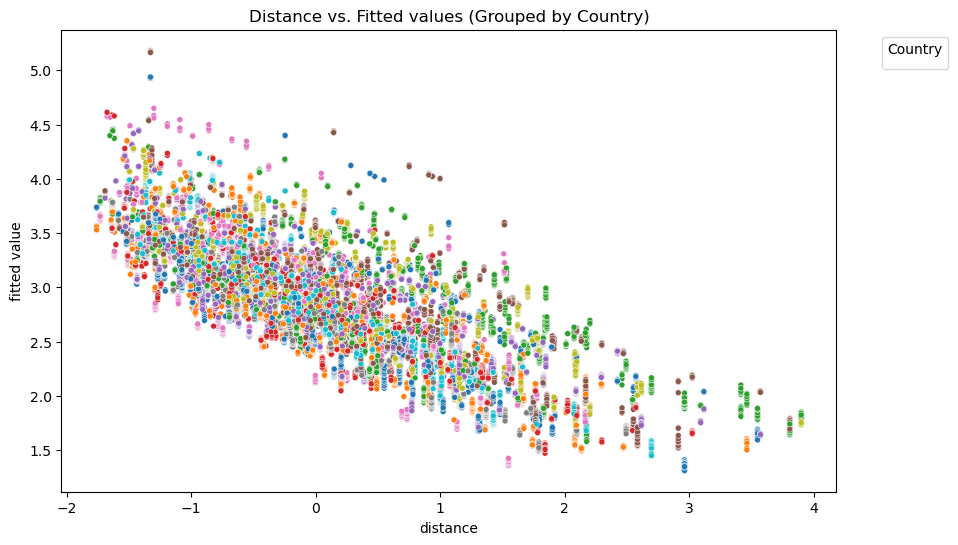

In [78]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="fitted_values", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10" , # Use a predefined palette
    legend=False
)
plt.xlabel("distance")
plt.ylabel("fitted value")
plt.title("Distance vs. Fitted values (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



/tmp/ipykernel_1738/3301902745.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')


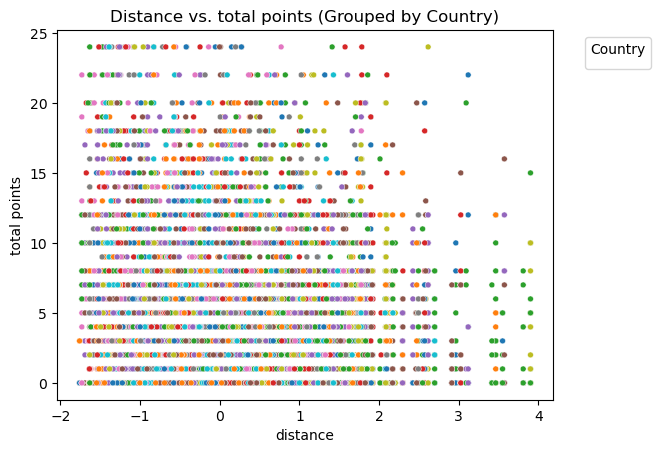

In [79]:
# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
#votes = votes[votes["from_country"] == "de"]
#plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="total_points", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10" , # Use a predefined palette
    legend=False
)
plt.xlabel("distance")
plt.ylabel("total points")
plt.title("Distance vs. total points (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

As we can see, the residuals clearly don't follow a normal distribution. Therefore our analysis should be regarded with caution

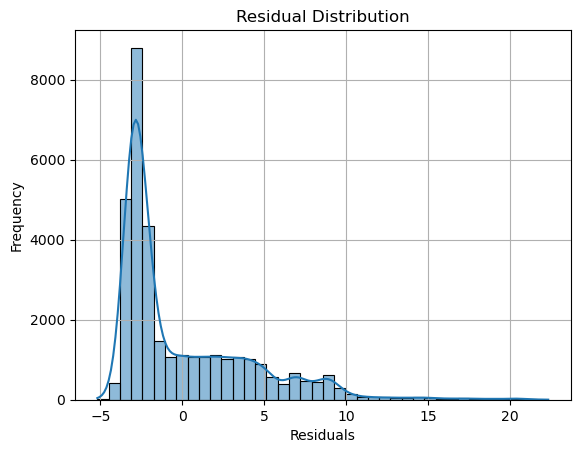

In [80]:
#plt.figure(figsize=(8, 5))
sns.histplot(votes["residuals"], bins=40, kde=True)

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.grid(True)

plt.savefig(f"../plots/linear_effects/residuals_{add_to_fig}.png")
plt.show()

Now we plot the data for two countries. This is meant to vizualize how good the model fits the data/ at least for distance.
also we see the difference some of the random effects can make. In the default settings, the random slope should be 0 

Distance mean: 1672.0979821958456
Distance std: 918.5086357589033
Slope: -0.5042250778784885
Intercept: 2.5897935610993237
Random intercept for Cyprus: 0.2491035893306586
Random intercept for Germany: -0.45361002828662833
Random slope for Germany: 0


/tmp/ipykernel_1738/492680016.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusion_votes["distance_original"] = exclusion_votes["distance"] * distance_std + distance_mean


<Figure size 1800x900 with 0 Axes>

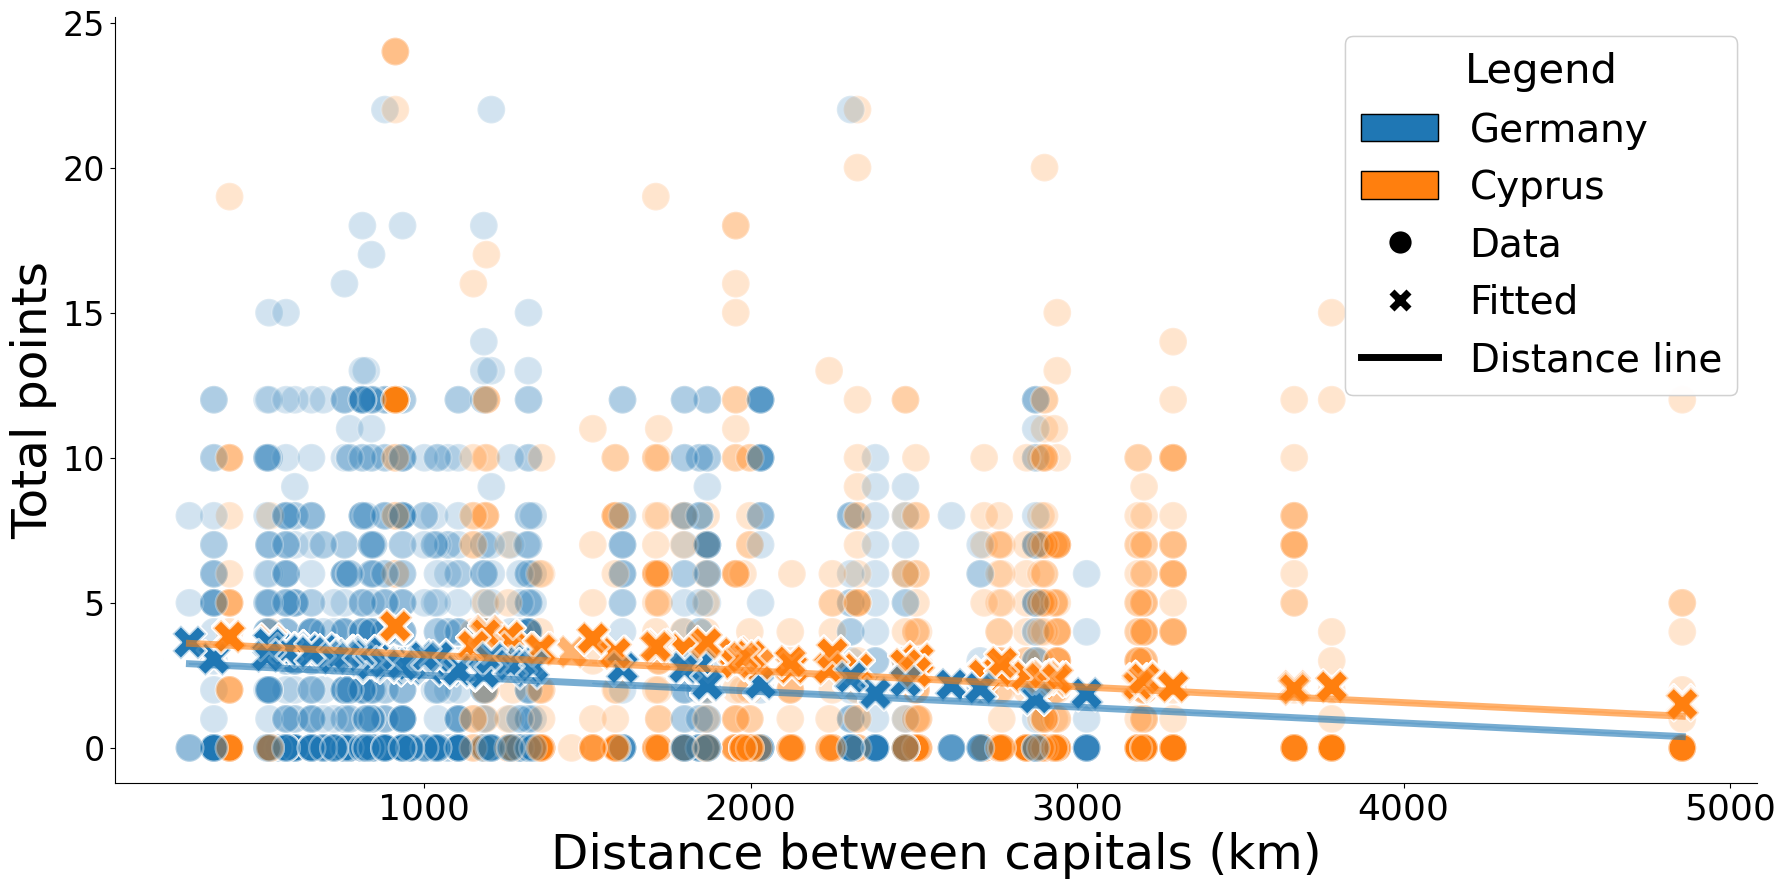

In [82]:
print("Distance mean:", distance_mean)
print("Distance std:", distance_std)

#  'votes' has columns 'country', 'distance', 'total_points', and 'fitted'


slope = mixed_model.params["distance"]
intercept = mixed_model.params["Intercept"]

print("Slope:", slope)
print("Intercept:", intercept)

random_effects = mixed_model.random_effects

#print("Random effects:")
#print(random_effects)
# For Spain ('es')
cyprus_random_intercept = random_effects.get('cy', {}).get('Group', 0)
germany_random_intercept = random_effects.get('de', {}).get('Group', 0)
germany_random_slope = random_effects.get('de', {}).get('distance', 0)
cyprus_random_slope = random_effects.get('cy', {}).get('distance', 0)
estonia_random_slope = random_effects.get('ee', {}).get('distance', 0)
estonia_random_intercept = random_effects.get('ee', {}).get('Group', 0)
print("Random intercept for Cyprus:", cyprus_random_intercept)
print("Random intercept for Germany:", germany_random_intercept)
print("Random slope for Germany:", germany_random_slope)

plt.figure(figsize=(18, 9))  # Made figure wider to accommodate legend
exclusion_votes = votes[votes["from_country"].isin([
    "de",
                                                    # "es",
                                                       "cy",
                                                        #"ee"
                                                       ])]# Plot actual points


# This is for un-normalizing the data
exclusion_votes["distance_original"] = exclusion_votes["distance"] * distance_std + distance_mean

original_slope_germany = (slope + germany_random_slope) / distance_std
original_intercept_germany = (intercept + germany_random_intercept) - original_slope_germany * distance_mean

original_slope_cyprus = (slope + cyprus_random_slope) / distance_std
original_intercept_cyprus = (intercept + cyprus_random_intercept) - original_slope_cyprus * distance_mean

original_slope_estonia = (slope + estonia_random_slope) / distance_std
original_intercept_estonia = (intercept + estonia_random_intercept) - original_slope_estonia * distance_mean

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Define colors (match seaborn palette)
colors = sns.color_palette("tab10", 10)
germany_color = colors[0] 
cyprus_color = colors[1]   

# Define legend entries
legend_elements = [[
   Patch(facecolor=germany_color, edgecolor='black', label="Germany"),
     Patch(facecolor=cyprus_color, edgecolor='black', label="Cyprus"),Line2D([0], [0], marker='o', color='w', markerfacecolor="black", markersize=17, label="Data"),
    Line2D([0], [0], marker='X', color='w', markerfacecolor="black", markersize=17, label="Fitted"),
     Line2D([0], [0], color="black", lw=5, label="Distance line")]]


fig, ax = plt.subplots(figsize=(18, 9))

# Plot the data
sns.scatterplot(data=exclusion_votes, x="distance_original", y="total_points", hue="from_country", palette="tab10", alpha=0.2, s=400, legend=False)
sns.scatterplot(data=exclusion_votes, x="distance_original", y="fitted_values", hue="from_country", palette="tab10", marker='X', s=600, alpha=0.6, legend=False)
sns.lineplot(data=exclusion_votes, x="distance_original", y=exclusion_votes["distance_original"] *original_slope_germany + original_intercept_germany, color=germany_color, alpha=0.6, linewidth=5)
sns.lineplot(data=exclusion_votes, x="distance_original", y=exclusion_votes["distance_original"] * original_slope_cyprus + original_intercept_cyprus, color=cyprus_color, alpha=0.6, linewidth=5)
#sns.lineplot(data=exclusion_votes, x="distance_original", y=exclusion_votes["distance_original"] * original_slope_estonia + original_intercept_estonia, color=colors[2], alpha=0.6, linewidth=5)
plt.xlabel("Distance between capitals (km)", fontsize=35)
plt.ylabel("Total points", fontsize=35)
plt.xticks(fontsize=26)
plt.yticks(fontsize=24)


table_legend = plt.legend(handles=[  # Empty placeholder for alignment
                                   *legend_elements[0],  # Data points
                                ],
                          title="Legend", title_fontsize=30, fontsize=28, loc='upper right', frameon=True)

plt.gca().add_artist(table_legend)  # Add to existing plot

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig(f"../plots/linear_effects/actual_vs_fitted_{add_to_fig}.png", dpi = 200)
plt.show()
